# Analysis of taxi trips

@Liubov, Alexey notebooks for WWCS

Notebook for the winter school WWCS for analysis of mobility data. 
It consist of several parts: 
1. locations analysis for spatial analysis (also scaling)
2. temporal analysis of trips distributions 
 

Here we consider the data of taxi drivers in New York [1]. For possible statistics and measures one can look at [2]. I also acknoledge help of C.Singh for important insights about the datasets and preparing time-dataset splitting.




# Open data on taxis

First of all why this data?
It is quite unique data on human mobility. 
Other types, such as banknote data [3] 
may be inaccurate, since banknote may change hands several times during the period of the recorded banknote travel. Especially, it would be difficult to trace the short-distance travels of human beings through the banknote records, e.g. in range of less than 10km as shown in Brockmann et al [3].

# Important!
**Please interrupt if you have questions!**

**Important to remember**: not every dataset is open even if you find it openly on the internet, always check the lisence if you get it from github, check references for papers. 


# Statistical measures 

Here we consider some of statistical properties of dataset: 
1. basic preprocessing of dataset
2. form of distributions of trips lengths and durations, 
3. number of trips hourly on a daily basis, 
4. trips distance vs. duration distribution, 
5. spatial distribution randomness measures. For other possible measures for the datasets look at [3].

**Some suggested references:**
1. Kaggle dataset to download https://www.kaggle.com/c/new-york-city-taxi-fare-prediction 
2. A. Noulas, V. Salnikov, R. Lambiotte, C. Mascolo, Yellow cabs analysis https://arxiv.org/abs/1508.07292
3. D. Brockmann, L. Hufnagel, T. Geisel, The scaling laws of human travel, Nature 439 (7075) (2006) 462–465


In [5]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


# 1. Locations analysis for spatial analysis 

# Loading data

Initially, we have the dataset of transportation of taxis around NY from open Kaggle dataset.
However it is easier to work with smaller datasets.
There are several **datasets:**
1. full dataset in the file `taxi_test.csv`
2. several datasets split into 6 time-zones datasets: 0:00-4:00, 4:00-8:00, 8:00-12:00, 12:00-16:00, 16:20, 20:00-24:00 in files `time_zone_i.csv`

In [20]:

filepath_data = "C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/" 

df = pd.read_csv(file_path + 'taxi_test.csv',sep=',')
print(df.shape)
df.head()


(625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


Let us read separate data-sets with $0:00-4:00$ and $8:00-12:00$ for making plots for spatial distribution.

In [6]:
#load data for time period 0:00-4:00 df_1
#load data for time period 8:00-12:00 df_3

filepath_data = "C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/time_zones/time_zone_1.csv" 
df_1 = pd.read_csv(filepath_data,sep=' ')
print(df_1.shape)

filepath_data = "C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/time_zones/time_zone_3.csv" 
df_3 = pd.read_csv(filepath_data,sep=' ')

print(df_3.shape)
df_3.head()

(140686, 9)
(268629, 9)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat
0,id3858529,2016-01-19,11:35:24,6.380,2124,-73.979027,40.763939,-74.005333,40.710087
1,id1299289,2016-05-15,11:16:11,3.777,1128,-73.991531,40.749439,-73.956543,40.770630
2,id1187965,2016-02-19,09:52:46,1.864,1114,-73.962982,40.756680,-73.984406,40.760719
3,id1154431,2016-04-14,08:48:26,2.536,731,-73.994255,40.745804,-73.999657,40.723343
4,id3552682,2016-06-27,09:55:13,4.603,1317,-74.003983,40.713013,-73.979195,40.749924


# Filtering data
Filter the data for trip distance more than $20$, less than $25$ km (for better seeing some trends). 


In [7]:

df_new = df_3[df_3.Distance > 20] 
df_new = df_new[df_new.Distance <= 25]

print(df_new.shape)
df_new.head()

(2945, 9)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat
6,id3321406,2016-06-03,08:15:05,20.612,2485,-73.955231,40.777134,-73.788750,40.641472
80,id2693863,2016-03-18,08:22:10,21.677,5109,-73.777184,40.646500,-73.985001,40.760918
138,id2833082,2016-06-14,09:03:49,20.934,2743,-73.992584,40.737293,-73.776764,40.644833
277,id1629416,2016-02-29,10:04:11,20.304,3345,-73.786102,40.639755,-74.003876,40.716850
354,id3247844,2016-05-18,09:48:22,21.629,3385,-73.983994,40.758961,-73.776352,40.645096


# Data preprocessing
First we make Duration to be in minutes.
Then we filter out new variable is "Duration" field (minutes) to be not longer than $86.14$ minutes (quantile of $75\%$).

In [8]:
#df_new["Duration(min)"] = df["Duration"]/60

df_new["Duration(min)"] = df_new["Duration"]/60

q1 = df_new["Duration(min)"].quantile(0.25)
q3 = df_new["Duration(min)"].quantile(0.75)
iqr = q3-q1
low_end = max(q1 - 1.5*iqr,0)
high_end = q3 + 1.5*iqr

print(low_end, high_end)

df_new = df_new[df_new["Duration(min)"] <= high_end]
print(df_new.shape)

df_new.sort_values("Duration(min)")

3.99166666666666 88.72500000000001
(2864, 10)


,tripID,Date,Time,Distance,Duration,pick_long,pick_lat,drop_long,drop_lat,Duration(min)
64696,id1247921,2016-01-11,11:56:08,20.657,840,-73.784966,40.648548,-73.956734,40.780918,14.000000
45667,id2617414,2016-03-20,08:53:43,20.734,1045,-73.929337,40.799358,-73.791794,40.644730,17.416667
249656,id1261113,2016-02-14,09:45:22,20.203,1164,-73.972603,40.749142,-73.776352,40.645279,19.400000
167522,id1063807,2016-01-01,09:52:20,20.038,1205,-73.976379,40.744179,-73.778358,40.644970,20.083333
115417,id0787003,2016-02-28,08:49:28,20.145,1235,-73.985603,40.746841,-73.789932,40.643261,20.583333
...,...,...,...,...,...,...,...,...,...,...
86013,id3673848,2016-04-18,09:05:27,21.461,5277,-73.782448,40.644527,-73.985695,40.760391,87.950000
146964,id3384508,2016-04-12,08:19:20,20.556,5284,-73.781982,40.644798,-73.979622,40.752686,88.066667
267792,id1942022,2016-04-21,10:12:58,21.643,5288,-73.776909,40.646111,-73.985214,40.759483,88.133333
199307,id0419291,2016-06-03,08:57:13,20.923,5304,-73.789993,40.646854,-73.983917,40.763988,88.400000


# Plotting
First let us plot the whole dataset.
Plotting geographic locations of the trips. For this we use BBox with latitude and longitude coordinates $(-74.1859, -73.6826, 40.4485, 40.9234)$. 
We plot separately 
1. drop-off and pickup locations
2. connections between drop-off and pickup locations

# Advice for plotting 
1. make points tranparent $\alpha =0.1$
2. for comparing two plots for the whole data set and time-slized datasets you can plot the difference "df - df1"  
3. you can use `folium` module for plotting on a map if you do not want to use saved `png` (for this one can use matplotlib) 
4. `osmnx` also visualises the data on a map

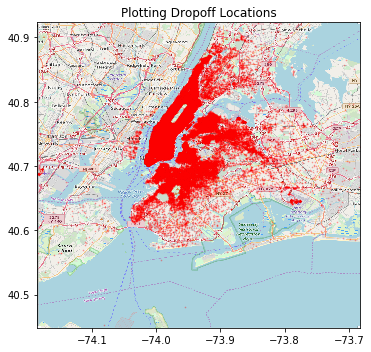

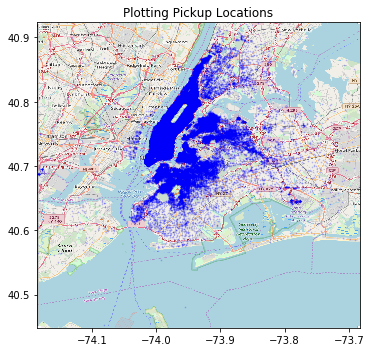

In [4]:
# choose box with coordinates of the region plotted
BBox = (-74.1859, -73.6826, 40.4485, 40.9234) # BBox = (-74.0293, -73.8939, 40.6982, 40.8687)

# path for the picture saved for plotting
file_path_png = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/nyc.png'
file_save_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/plots_jupyter/'

#df = df_1 df = df_new

#nyc = plt.imread('')
nyc = plt.imread(file_path_png)

x_pos, y_pos = list(df.pick_long), list(df.pick_lat)
x_f,y_f = list(df.drop_long), list(df.drop_lat)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
# ax.scatter(df.pick_long, df.pick_lat, zorder=2, alpha= 0.2, c='b', s=15)
ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'dropoff.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df.drop_long, df.drop_lat, zorder=2, alpha= 0.2, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'pickup.png')
plt.show()



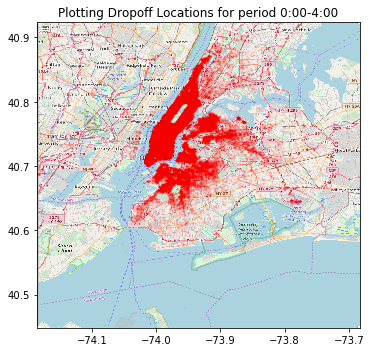

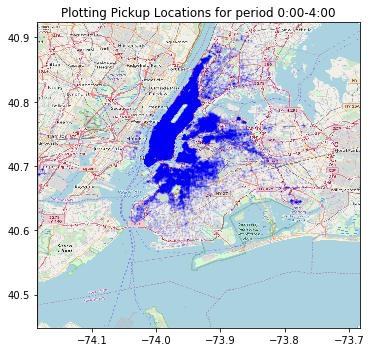

In [14]:

# load image we will be plotting on
BBox = (-74.1859, -73.6826, 40.4485, 40.9234) # BBox = (-74.0293, -73.8939, 40.6982, 40.8687)
#file_path_png = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/nyc.png'
file_save_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/plots_jupyter/'

file_path = '/home/user1/Documents/Data_Analysis/nyc/'
nyc = plt.imread(file_path+ 'nyc.png')


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df_1.drop_long, df_1.drop_lat, zorder=1, alpha= 0.1, c='r', s=0.5)
ax.set_title('Plotting Dropoff Locations for period 0:00-4:00')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'plots_jupyter/dropoff.png')
plt.show()


fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(df_1.drop_long, df_1.drop_lat, zorder=2, alpha= 0.1, c='b', s=0.5)
# ax.scatter(df.drop_long, df.drop_lat, zorder=1, alpha= 0.3, c='r', s=15)
ax.set_title('Plotting Pickup Locations for period 0:00-4:00')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save+'plots_jupyter/pickup.png')
plt.show()



Plotting trips using quiver function.

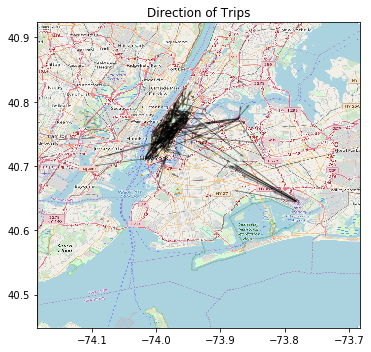

In [15]:
# for plotting trips we use quiver function

x_pos, y_pos = list(df_1.pick_long), list(df_1.pick_lat)
x_f,y_f = list(df_1.drop_long), list(df_1.drop_lat)

d_x = list(map(lambda x: x[0]-x[1], zip(x_f,x_pos)))
d_y = list(map(lambda x: x[0]-x[1], zip(y_f,y_pos)))

fig, ax = plt.subplots(figsize = (8,5))
ax.quiver(x_pos[::500],y_pos[::500],d_x[::500],d_y[::500], scale=1 , alpha=0.5, color='black')
ax.set_title('Direction of Trips')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nyc, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig(file_save_path+'/quiver_diag.png')
plt.show()


Plot places that take longer time to reach. We filter out data, which are with duration in minutes of more than 25 min.

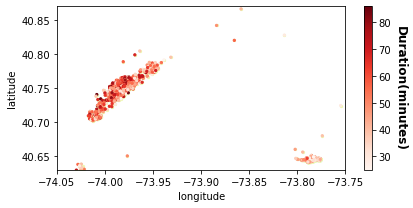

In [17]:
from matplotlib import cm


BBox = (-74.05, -73.75, 40.63, 40.87)
xmin,xmax,ymin,ymax = BBox[0],BBox[1],BBox[2],BBox[3]
x,y,dur = df_new.drop_long, df_new.drop_lat, df_new["Duration(min)"]


#get those trips, which are further than 25 minutes
Drop = list(zip(x,y,dur))
x1,y1,dur1 = [],[],[]
for i,j,k in Drop:   
    if k>=25:
        x1.append(i)
        y1.append(j)
        dur1.append(k)

fig, ax = plt.subplots(figsize = (6,3))
# ax.scatter(x0,y0, zorder=1, alpha= 0.3, c='b', s=0.3)
ax.scatter(x,y, zorder=1, alpha= 1, c='#edf8b1', s=5)
# ax.set_title('Plotting Dropoff Locations')

xx = np.ravel(x1); yy = np.ravel(y1) ; zz = np.ravel(dur1)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

plt.scatter(xx,yy,c=zz,cmap=cm.Reds,s=5)
cbar = plt.colorbar()
cbar.set_label("Duration(minutes)", labelpad=15,rotation=270, fontsize=12,fontweight='bold')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.tight_layout()
#plt.savefig('')
plt.show()


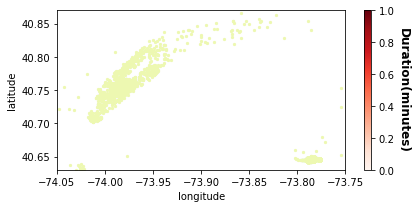

In [25]:
#plotting places which are faster than 5min to reach

from matplotlib import cm


BBox = (-74.05, -73.75, 40.63, 40.87)
xmin,xmax,ymin,ymax = BBox[0],BBox[1],BBox[2],BBox[3]
x,y,dur = df_new.drop_long, df_new.drop_lat, df_new["Duration(min)"]


#get those trips, which are further than 25 minutes
Drop = list(zip(x,y,dur))
x1,y1,dur1 = [],[],[]
for i,j,k in Drop:   
    if k<5:
        x1.append(i)
        y1.append(j)
        dur1.append(k)

fig, ax = plt.subplots(figsize = (6,3))
# ax.scatter(x0,y0, zorder=1, alpha= 0.3, c='b', s=0.3)
ax.scatter(x,y, zorder=1, alpha= 1, c='#edf8b1', s=5)
# ax.set_title('Plotting Dropoff Locations')

xx = np.ravel(x1); yy = np.ravel(y1) ; zz = np.ravel(dur1)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

plt.scatter(xx,yy,c=zz,cmap=cm.Reds,s=5)
cbar = plt.colorbar()
cbar.set_label("Duration(minutes)", labelpad=15,rotation=270, fontsize=12,fontweight='bold')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.tight_layout()
#plt.savefig('')
plt.show()


# Calculating some statistics for spatial analysis

We start with calculating  trip distance and trip duration distributions were calculated. For that we can use python `fitter` module.

**Note:** notebook cells below should be executed sequently.

In [10]:
from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as sts

In [9]:
file_path = 'C:/Users/lyubo/Documents/DATA_networks/mobilitydata/data_taxi/nyc/'
df = pd.read_csv(file_path+'dist_time.csv',sep=' ')

df.Duration = df.Duration/60
# removing outliers 
q1 = df["Duration"].quantile(0.25)
q3 = df["Duration"].quantile(0.75)

iqr = q3-q1
low_end = max(q1 - 1.5*iqr,0)
high_end = q3 + 1.5*iqr

print(low_end, high_end)

# make new dataframe with duration less than upper quantile
df_new = df[df["Duration"] <= high_end]

# function "describe()" gives some statistics, max or min values
print("Distance statistics")
print(df_new.Distance.describe())
print("Duration - Minutes")
print(df_new["Duration"].describe())
print('\n')

0 34.866666666666674
Distance statistics
count    1.384424e+06
mean     2.912597e+00
std      3.294604e+00
min      0.000000e+00
25%      1.199000e+00
50%      1.993000e+00
75%      3.486000e+00
max      1.240510e+03
Name: Distance, dtype: float64
Duration - Minutes
count    1.384424e+06
mean     1.219504e+01
std      7.468468e+00
min      1.666667e-02
25%      6.400000e+00
50%      1.053333e+01
75%      1.651667e+01
max      3.486667e+01
Name: Duration, dtype: float64




 Plot cumulative distribution of trips distance.

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


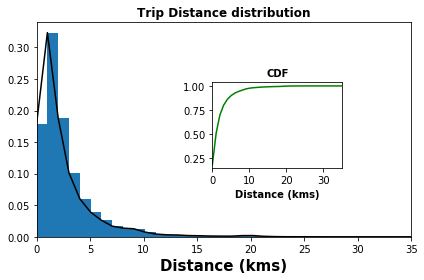

In [17]:
bins_dist = []
bins_time = []

bins_dist = np.linspace(0,100,100)
data = list(zip(df_new.Distance, df_new["Duration"]))

from collections import defaultdict
Distance_dist = defaultdict(int)

y = [i for i,j in data]

# CDF = [counts[0]]
# for i in range(1,len(counts)):
#     CDF.append(CDF[i-1] + counts[i])


fig, ax1 = plt.subplots()
left, bottom, width, height = [0.5, 0.4, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

counts,bins,_ = ax1.hist(y,bins=bins_dist,density=True)
ax1.plot(bins[:-1],counts, color='k')
ax1.set_xlim(0,35)
ax1.set_xlabel("Distance (kms)", fontsize = 15, fontweight= 'bold')
ax1.set_title("Trip Distance distribution", fontsize = 12, fontweight= 'bold')

ax2.plot(bins[:-1],np.cumsum(counts*(bins[1:]-bins[:-1])), color='green')
ax2.set_xlim(0,35)
ax2.set_xlabel("Distance (kms)", fontsize = 10, fontweight= 'bold')
ax2.set_title("CDF",fontsize = 10, fontweight= 'bold')
plt.tight_layout()
plt.savefig(file_path+'/plots/data_distance_dist.pdf')
plt.show()

# Distributions and scaling analysis of spatial and temporal characteristics

We first consider distributions for different days of the week. The goal is to understand if during different days distributions look different. 
We use `fit` function here.


In [12]:
# First we plot distributions fit

from datetime import datetime
from geopy.distance import geodesic
import numpy as np
import math
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import norm

# days = ["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
days = ["Sat","Sun"]

for weekD in days:

    df = pd.read_csv(file_path +'/weekdays/%s_trips.csv'%(weekD),sep=' ')

    q1 = df.Distance.quantile(0.25) # removing outliers 
    q3 = df.Distance.quantile(0.75)

    iqr = q3-q1

    low_end = max(q1 - 1.5*iqr,0)
    high_end = q3 + 1.5*iqr

    print('Distance -- ',low_end, high_end, math.ceil(high_end))

    distance = [n for n in list(df.Distance) if n>low_end and n<=high_end]

    df.Duration = df.Duration/60

    q1_t = df.Duration.quantile(0.25)
    q3_t = df.Duration.quantile(0.75)

    iqr_t = q3_t - q1_t

    low_end_t = max(q1_t - 1.5*iqr_t,0)
    high_end_t = q3_t + 1.5*iqr_t

    print('Duration -- ', low_end_t, high_end_t, math.ceil(high_end_t))

    duration = [n for n in list(df.Duration) if n>low_end_t and n<=high_end_t]

    

    #### fitting distance distribution with normal ##########

    bins_d = np.arange(0.01,math.ceil(high_end),0.1)

    mean, var = sts.norm.fit(distance) #alpha,loc,beta = sts.lognorm.fit(distance)

    y_d = sts.norm.pdf(bins_d, mean) #lognorm.pdf(x, s)    
    
    #print('KS test', sts.kstest(distance, 'norm')) # Kolmogorov-Smirnov test
    
    ########## fitting distance distribution  ###################

    bins_d = np.arange(0.01,math.ceil(high_end),0.1)

    alpha,loc,beta = sts.gamma.fit(distance)

    y_d = sts.gamma.pdf(bins_d,alpha,loc=loc,scale=beta)
    
    #print('KS test', sts.kstest(distance, 'norm'))

    ############### plotting distance Distribution ###############

    plt.plot(bins_d,y_d,'--', linewidth=3, label = r"$Gamma\hspace{1}Fit : \alpha = %0.2f, \beta = %0.2f$"%(alpha,beta))
    counts_d,bins_D,_ = plt.hist(distance,bins=bins_d,density=True, alpha=0.5, label="Data : mean= %0.2f, median= %0.2f, std = %0.2f"%(np.average(distance), np.median(distance), np.std(distance)))
    plt.legend(prop={'size':10})
    plt.xlabel('Distance (kms)', fontsize=15,fontweight='bold')
    plt.ylabel('Counts', fontsize=15,fontweight='bold')
    plt.tight_layout()
    plt.savefig('%s_dist.pdf'%(weekD))
    plt.show()

    ############# fitting duration distribution ##############

    bins_t = np.arange(0.01,math.ceil(high_end_t),0.2)

    alpha_t,loc_t,beta_t = sts.gamma.fit(duration)
    y_t = sts.gamma.pdf(bins_t,alpha_t,loc=loc_t,scale=beta_t)

    ################ plotting duration distribution ###################

    plt.plot(bins_t,y_t,'--', linewidth=3, label = r"$Gamma\hspace{1}Fit : \alpha = %0.2f, \beta = %0.2f$"%(alpha_t,beta_t))
    counts_t,bins_t,_ = plt.hist(duration,bins=bins_t,density=True, alpha=0.5, label="Data : mean= %0.2f, median= %0.2f, std = %0.2f"%(np.average(duration), np.median(duration), np.std(duration)))
    plt.legend(prop={'size':10})
    plt.xlabel('Duration (mins.)', fontsize=15,fontweight='bold')
    plt.ylabel('Counts', fontsize=15,fontweight='bold')
    plt.tight_layout()
    plt.savefig('%s_duration.pdf'%(weekD))
    plt.show()

Distance --  0 7.702999999999999 8
Duration --  0 32.541666666666664 33


TypeError: _parse_args() missing 1 required positional argument: 'a'

Comments on distribution shape:
    González et al. studied the trajectories of 100,000 mobile-phone users, finding that the distribution of displacements over all users was well approximated by a truncated power-law. In some papers it was found that distributions resembles fat tailed Gamma distribution $\frac{ \beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)} $. At the same time distribution of displacements of individuals  can to some extent be represented as heterogeneous random walks. 

# Spatial distribution regularity
The simplest forms of spatial data are gridded data, in which a scalar quantity is measured for each point in a regular grid of points. For taxi drop-offs and drop-in we assume some irregularities. We check it using G-distance.  For a given distance $d$, G-distance $G(d)$ is the proportion of nearest neighbor distances that are less than $d$. If the underlying process of the distribution is a CSR (Complete Spatial Randomness), $G$ function has an expectation of $G(d) = 1-exp(-\lambda \pi d^2)$.
For this we can use `libpysal` (if you need to work with shape files and geospatial files, we won't today) and `pointpats` libraries in python https://github.com/pysal/pointpats/blob/master/notebooks/pointpattern.ipynb 

**Point patterns** - series of point locations, $(s_1, s_2, \ldots, s_n)$ in a study region $\Re$. We limit our focus here to a two-dimensional space so that $s_j = (x_j, y_j)$ is the spatial coordinate pair for point location $j$. See more here https://en.wikipedia.org/wiki/Complete_spatial_randomness

In [29]:
import libpysal as ps


C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\libpysal\weights\util.py:20: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


In [32]:
from datetime import datetime
from geopy.distance import geodesic
from pointpats import PointPattern, PoissonPointProcess, as_window, G, Genv
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

df = pd.read_csv(file_path + 'train.csv',sep=',')
df.head()


X,Y = df.dropoff_longitude, df.dropoff_latitude

X = X[::100]
Y = Y[::100]

points = zip(X,Y)

pp = PointPattern(points)

pp.summary()




Point Pattern
14587 points
Bounding rectangle [(-74.25516510009766,40.54673385620117), (-73.53374481201173,41.031044006347656)]
Area of window: 0.3493911680416133
Intensity estimate for window: 41749.76740757985
           x          y
0 -73.964630  40.765602
1 -73.972008  40.745781
2 -73.947418  40.779633
3 -74.009850  40.721699
4 -73.982880  40.778297


If some functions are complicated, you are welcome to read about pointpats. 
http://pysal.org/notebooks/explore/pointpats/intro.html


In [33]:
# some complicated functions, you are welcome to read
# maximum number of nearest neighbors 
pp.max_nnd

0.11759639948523957

In [34]:
pp.min_nnd

0.0

Text(0, 0.5, 'Latitude')

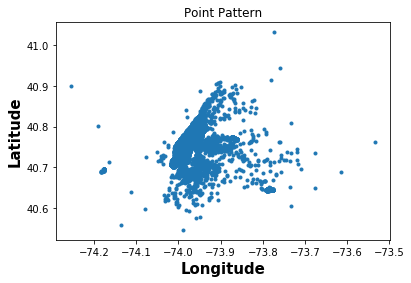

In [35]:
pp.plot()
# plt.tight_layout()
plt.xlabel('Longitude', fontsize=15,fontweight='bold')
plt.ylabel('Latitude', fontsize=15,fontweight='bold')
#plt.savefig('dropoff_pointPattern.pdf')

For completely spatial randomness one expects the intensity to be as for Poisson point process...

# 2. Temporal characteristics
Here we calculate several temporal statistics of trips:
1. trips duration distributions (and fit to Gamma function - **Excercise for understanding**)
2. trips length vs.duration distribution 


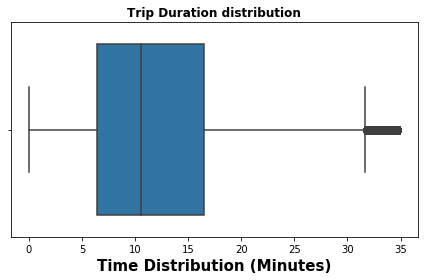

In [11]:
import seaborn as sns


#plt.plot(df_new["Duration"].values)
#plt.show()

# legend = ["time zone 1"]
sns.boxplot(x = df_new["Duration"])
#plt.plot(df_new["Duration"])
# plt.legend(legend, prop={'size':15})
plt.title("Trip Duration distribution", fontsize = 12, fontweight= 'bold')
plt.xlabel('Time Distribution (Minutes)', fontsize = 15, fontweight= 'bold')

plt.tight_layout()
plt.savefig(file_path +'/plots/data_time_dist.pdf')
plt.show()




C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


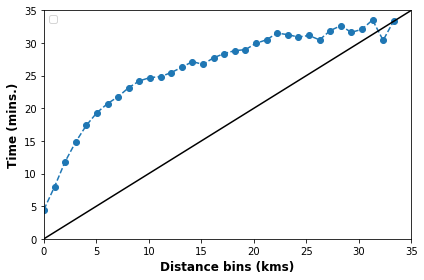

In [20]:


# calculate time variance distributions for different distance bins
len(bins)
time_var = {}
for i in range(99):
    time_var[bins[i]] = [x[1] for x in data if x[0] >= bins[i] and x[0] < bins[i+1]]
del_T = {}


#from time_var we also estimate del_T as median for time_var (variance of distributiona)
for i in time_var:
    del_T[i] = (np.median(time_var[i]), np.std(time_var[i]))

x,y,yerr = [],[],[]
for i in del_T:
    x.append(i)
    y.append(del_T[i][0])
    yerr.append(del_T[i][1])

plt.plot(x,y,'--o')
plt.plot(range(40),range(40),'-',color='black')
plt.xlim(0,35)
plt.ylim(0,35)
plt.legend()
plt.ylabel("Time (mins.)", fontsize=12,fontweight='bold')
plt.xlabel("Distance bins (kms)", fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig(file_path +'plots/data_mobility.pdf')
plt.show()

# tODO make it not BOX plot

# 2. Temporal properties 
Distribution of trips over time by hours. 

In [ ]:
#apply it to the big dataframe

df['Hour'] = df['pickup_datetime'].apply(lambda x: 
                                    (datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).hour)


hourly_trips = df.Hour
plt.hist(hourly_trips,bins=24,density=True)
plt.xlabel("Hour",fontsize=18,fontweight='bold')
plt.title("Hourly variation in #Trips",fontsize=18,fontweight='bold')
plt.xlim(0,23)
plt.tight_layout()
# plt.savefig('hourly_trips.pdf')

# Additional hints 
For spatial analysis we can use `osmnx` module for plotting streets of Manhattan and distribution of amenities vs. distribution of dropoffs.  
**Excercise for plotting** amenities on a map.

In [3]:
import pyproj
import cartopy.crs as ccrs

In [ ]:
import osmnx as ox

import matplotlib.pyplot as plt
import numpy as np

def plot_city(name_city_distr): 
    ''' given city district get information about schools there
    phone or email, 
    availability of data 
    format of name_city_distr "Kamppi, Helsinki, Finland"
    
    name_city_distr must be a shapely Polygon or MultiPolygon. If you requested graph from place name or address, make sure your query resolves to a Polygon or MultiPolygon, and not some other geometry, like a Point. See OSMnx documentation for details.
    '''
    
    place_name = name_city_distr # e.g. "Kamppi, Helsinki, Finland"
    
    # Fetch OSM street network from the location
    graph = ox.graph_from_place(place_name)
    type(graph)

    print('loading graph of city')

    # Plot the streets
    fig, ax = ox.plot_graph(graph)
    plt.show()

name_city = 'Manhatthan, USA'
plot_city(name_city)    

